In [642]:
import pandas as pd
import numpy as np 
from qdl.facade import QDL 
from qdl import  validator 
import matplotlib.pyplot as plt
q = QDL()

In [593]:
import pandas as pd
import numpy as np 
from qdl.facade import QDL 
q = QDL()

selected_cols = ['date', 'id', 'size_grp', 'me', 'be_me', 'ope_be', 'at_gr1', 'ret_12_1', 'ret_1_0', 'ret_exc_lead1m', 'eom']
chars_df = q.load_char_dataset(
    country="usa",
    vintage="1972-",
    columns= selected_cols ,
    strict=True
)

In [594]:
print(chars_df.shape)
print(chars_df.dtypes)

chars_df['date'] = pd.to_datetime(chars_df['date'], format='%Y%m')
# 'date' 컬럼에서 따로 만들어 쓰던 'yearmonth'를 
# 'eom' 컬럼으로 대체하여 사용함
chars_df['year_month'] = chars_df['eom']  


chars_df.head()

(3572680, 11)
date              datetime64[ns]
id                       float64
size_grp                  object
me                       float64
be_me                    float64
ope_be                   float64
at_gr1                   float64
ret_12_1                 float64
ret_1_0                  float64
ret_exc_lead1m           float64
eom               datetime64[ns]
dtype: object


,date,id,size_grp,me,be_me,ope_be,at_gr1,ret_12_1,ret_1_0,ret_exc_lead1m,eom,year_month
0,1978-12-29,33321.0,small,125.00,NaN,NaN,NaN,0.246967,-0.019608,0.012118,1978-12-31,1978-12-31
1,1979-01-31,33321.0,small,127.50,NaN,NaN,NaN,0.251798,0.020000,-0.005363,1979-01-31,1979-01-31
2,1979-02-28,33321.0,small,126.25,NaN,NaN,NaN,0.276834,0.001961,-0.028730,1979-02-28,1979-02-28
3,1979-03-30,33321.0,small,123.75,NaN,NaN,NaN,0.159839,-0.019802,-0.079196,1979-03-31,1979-03-31
4,1979-04-30,33321.0,small,115.00,NaN,NaN,NaN,0.149504,-0.070707,0.015752,1979-04-30,1979-04-30


In [595]:
#id(키값)에 중복이 있는지 확인 
chars_df.head()
chars_df.groupby(['id','year_month']).size().reset_index(name='cnt').sort_values(by='cnt', ascending=False).head(5)
chars_df.groupby(['year_month', 'id']).size().reset_index(name='cnt').sort_values(by='cnt', ascending=False).head(5)

,year_month,id,cnt
0,1972-01-31,10006.0,1
1,1972-01-31,10014.0,1
2,1972-01-31,10057.0,1
3,1972-01-31,10102.0,1
4,1972-01-31,10137.0,1


In [596]:
chars_df.isnull().sum()

date                   0
id                     0
size_grp           51229
me                 51229
be_me             448871
ope_be            877728
at_gr1            454839
ret_12_1          367931
ret_1_0           107024
ret_exc_lead1m     94530
eom                    0
year_month             0
dtype: int64

In [597]:
print(chars_df.shape)
chars_df = chars_df[~chars_df['size_grp'].isnull() ==True] #size grp에 존재하는 null 값 제거 
chars_df['me_neg'] = chars_df['me']

print(chars_df.shape)

(3572680, 12)
(3521451, 13)


In [598]:
chars_df.groupby('size_grp')['year_month'].nunique() #size grp별로 몇개씩 존재하는지 체크 

size_grp
large    636
mega     638
micro    636
nano     636
small    636
Name: year_month, dtype: int64

In [599]:
# 기간을 unique하게 추출 
df_period  = pd.DataFrame(chars_df['year_month'].unique(), columns=['year_month']).sort_values(by='year_month')
print(chars_df['year_month'].nunique())

#분위수 잡기 위해, non-micro 추출 
chars_no_micro = chars_df[~chars_df['size_grp'].isin(['micro', 'nano'])] 

638


### 'hml', 'rmw', 'cma', 'mom', 'str' factor 복제

In [600]:
# other factors
columns_list = ['be_me', 'ope_be', 'at_gr1', 'ret_12_1', 'ret_1_0', 'me_neg'] # test 용 
factor_name = ['hml', 'rmw', 'cma', 'mom', 'str']

all_results = []
for c in columns_list: 
    sub = chars_no_micro[[ 'year_month', c ]].dropna().copy()
    sub['rk'] = sub.groupby('year_month')[c].rank(method='min', pct=True)
    bps = (
        sub.groupby('year_month')
        .apply(lambda g: pd.Series({
            f'{c}_low' : g.loc[g['rk'] <= 0.333, c].max(),
            f'{c}_high': g.loc[g['rk'] >= 0.666, c].min(),
        }))
        .reset_index()
        .sort_values('year_month')
    )

    cut_off_df = chars_df.merge(bps, on='year_month', how='left')
    print(chars_df['year_month'].nunique())
    cut_off_df['cut_off'] = np.where(cut_off_df[c] < cut_off_df[f'{c}_low'], 'low', np.where(cut_off_df[c] > cut_off_df[f'{c}_high'], 'high', 'middle'))
    cut_off_df['me_ret'] = cut_off_df['me'] * cut_off_df['ret_exc_lead1m']
    cut_off_df = cut_off_df.merge(cut_off_df.groupby(['year_month'])['me'].quantile(0.8).reset_index(name= 'me_capped')
                 , on = 'year_month', how='left')
    cut_off_df['cap_me'] = np.minimum(cut_off_df['me_capped'], cut_off_df['me'])
    cut_off_df['cap_me_ret'] = cut_off_df['cap_me'] * cut_off_df['ret_exc_lead1m']

    query = (cut_off_df['cut_off'].isin(['high'])) & (~cut_off_df['size_grp'].isin(['micro', 'nano']))

    df_big = cut_off_df.loc[query, ].groupby('year_month').agg(
        mean = ('ret_exc_lead1m', 'mean'),
        me_sum_big = ('me', 'sum'),
        me_ret_sum_big = ('me_ret', 'sum'),
        me_cap_sum_big = ('cap_me', 'sum'),
        me_cap_ret_sum_big = ('cap_me_ret', 'sum'),
        n_big = ('id', 'nunique')
    ).rename(columns={'mean':'mean_big'}).reset_index()

    query = (cut_off_df['cut_off'].isin(['low']))  &  (~cut_off_df['size_grp'].isin(['micro', 'nano']))

    df_small = cut_off_df.loc[query, ].groupby('year_month').agg(
        mean = ('ret_exc_lead1m', 'mean'),
        me_sum_small = ('me', 'sum'),
        me_ret_sum_small = ('me_ret', 'sum'),
        me_cap_sum_small = ('cap_me', 'sum'),
        me_cap_ret_sum_small = ('cap_me_ret', 'sum'),
        n_small = ('id', 'nunique')
    ).rename(columns={'mean':'mean_small'}).reset_index()

    df = df_period.merge(df_big, on='year_month' , how='inner')
    df = df.merge(df_small, on='year_month' , how='inner')
    print(df.shape)

    if c in ['ret_1_0', 'at_gr1', 'me_neg']: 
        df['ret_ew'] =  -1*(df['mean_big'] - df['mean_small'])
        df['ret_vw'] = -1*(df['me_ret_sum_big']/df['me_sum_big'] - df['me_ret_sum_small']/df['me_sum_small'] )
        df['ret_capped_vw'] = -1*(df['me_cap_ret_sum_big']/df['me_cap_sum_big'] - df['me_cap_ret_sum_small']/df['me_cap_sum_small'] )
    else:
        df['ret_ew'] =  (df['mean_big'] - df['mean_small'])
        df['ret_vw'] = (df['me_ret_sum_big']/df['me_sum_big'] - df['me_ret_sum_small']/df['me_sum_small'] )
        df['ret_capped_vw'] = (df['me_cap_ret_sum_big']/df['me_cap_sum_big'] - df['me_cap_ret_sum_small']/df['me_cap_sum_small'] )

    query =  (df['n_big'] >= 5) & (df['n_small'] >= 5)

    df = df.loc[query , ] 
    results = df.loc[:,['year_month','ret_ew', 'ret_vw', 'ret_capped_vw', 'n_big', 'n_small']]
    results['name'] = c
    all_results.append(results)

final_results = pd.concat(all_results, ignore_index=True)
final_results = final_results.rename(columns={'year_month' :'date'})
final_results = final_results.set_index('date')
final_results.index = final_results.index + pd.DateOffset(months=1)

final_results.head()

C:\Users\User\AppData\Local\Temp\ipykernel_32780\1497999484.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


638
(637, 13)


C:\Users\User\AppData\Local\Temp\ipykernel_32780\1497999484.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


638
(638, 13)


C:\Users\User\AppData\Local\Temp\ipykernel_32780\1497999484.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


638
(638, 13)


C:\Users\User\AppData\Local\Temp\ipykernel_32780\1497999484.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


638
(638, 13)


C:\Users\User\AppData\Local\Temp\ipykernel_32780\1497999484.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


638
(638, 13)


C:\Users\User\AppData\Local\Temp\ipykernel_32780\1497999484.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


638
(638, 13)


,ret_ew,ret_vw,ret_capped_vw,n_big,n_small,name
date,,,,,,
1972-02-29,-0.037187,-0.049118,-0.043874,458,455,be_me
1972-03-29,-0.018972,-0.025557,-0.014005,452,450,be_me
1972-04-30,-0.004905,-0.026692,-0.005942,457,454,be_me
1972-05-30,-0.050430,-0.013333,-0.049889,475,473,be_me
1972-06-30,-0.017247,-0.033412,-0.022476,479,477,be_me


In [601]:
factors_df = final_results.copy()
final_results = final_results[final_results['name'] != 'me_neg']

### ew

In [602]:
investment_factor_answer =q.load_factors(
    country="usa",
    dataset='factor',
    weighting='ew',
    factors=['be_me', 'ope_be', 'at_gr1', 'ret_12_1', 'ret_1_0'],
)

In [603]:
investment_factor_answer.head()

,be_me,ope_be,at_gr1,ret_12_1,ret_1_0
date,,,,,
1926-01-31,NaN,NaN,NaN,NaN,NaN
1926-02-28,NaN,NaN,NaN,NaN,0.000148
1926-03-31,NaN,NaN,NaN,NaN,-0.056706
1926-04-30,NaN,NaN,NaN,NaN,-0.014048
1926-05-31,NaN,NaN,NaN,NaN,-0.012404


In [604]:
def _fmt(x):
    return f"{x:.3f}" if x is not None else "nan"

  Factor   N      Start        End      MSE     RMSE      MAE     Corr
   be_me 370 1972-02-29 2024-11-30 0.000326 0.018043 0.012773 0.921034
  ope_be 370 1972-02-29 2024-11-30 0.000524 0.022886 0.014987 0.797430
  at_gr1 370 1972-02-29 2024-11-30 0.000330 0.018160 0.012649 0.816101
ret_12_1 370 1972-02-29 2024-11-30 0.000458 0.021395 0.014831 0.894356
 ret_1_0 370 1972-02-29 2024-11-30 0.000385 0.019623 0.012938 0.869873


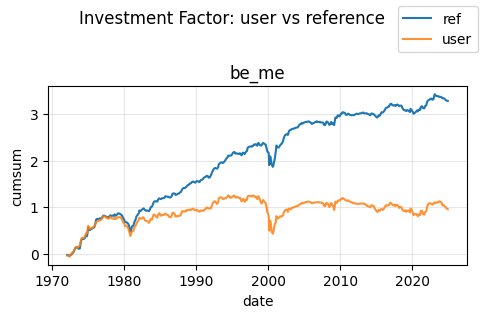

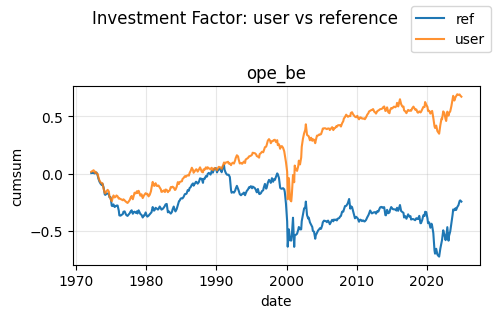

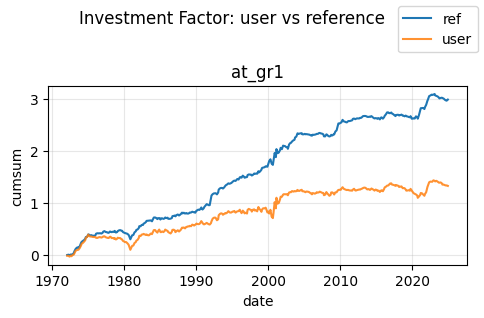

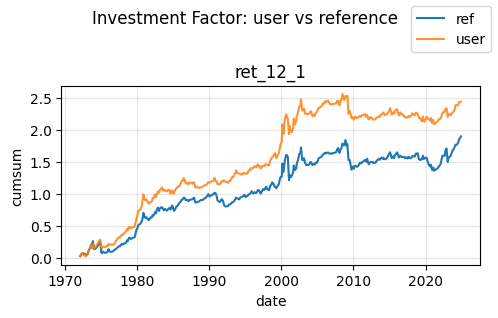

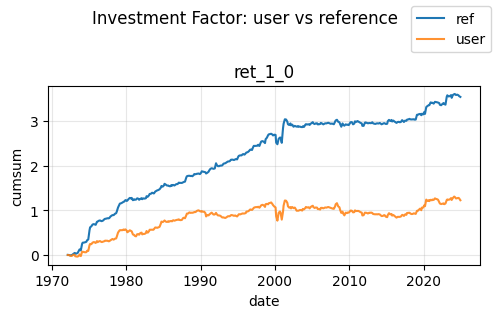

In [605]:
report_data = []
for name in final_results['name'].unique():
    test = final_results[final_results['name'] == name].loc[:, ['ret_ew']].rename(columns= {'ret_ew' : name})
    report = validator.validate_factor(
        user=test,
        reference=investment_factor_answer.loc[:, [name]],
        return_plot=True,
        plot_title="Investment Factor: user vs reference",
    )
    report_data.append({
        "Factor": name,
        "N": report.n_obs,
        "Start": report.date_start.date(),
        "End": report.date_end.date(),
        "MSE": report.mse,
        "RMSE": report.rmse,
        "MAE": report.mae,
        "Corr": report.corr,
    })

results_df = pd.DataFrame(report_data)
print(results_df.to_string(index=False))

### vw

In [606]:
investment_factor_answer =q.load_factors(
    country="usa",
    dataset='factor',
    weighting='vw',
    factors=['be_me', 'ope_be', 'at_gr1', 'ret_12_1', 'ret_1_0'],
)

  Factor   N      Start        End      MSE     RMSE      MAE     Corr
   be_me 370 1972-02-29 2024-11-30 0.000004 0.002028 0.001211 0.998619
  ope_be 370 1972-02-29 2024-11-30 0.000005 0.002199 0.001594 0.997715
  at_gr1 370 1972-02-29 2024-11-30 0.000002 0.001237 0.000822 0.999375
ret_12_1 370 1972-02-29 2024-11-30 0.000003 0.001861 0.001273 0.999313
 ret_1_0 370 1972-02-29 2024-11-30 0.000003 0.001755 0.001163 0.998832


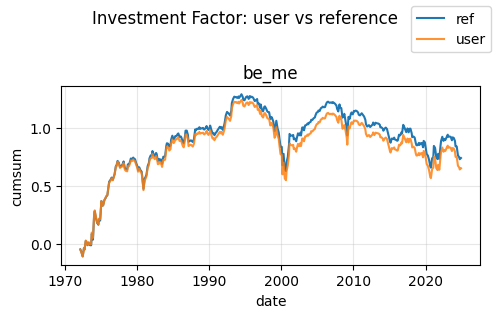

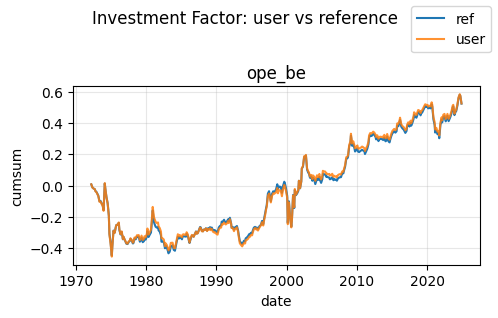

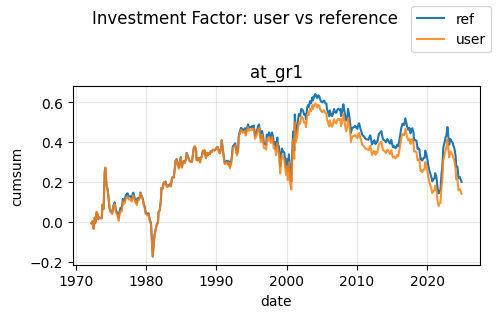

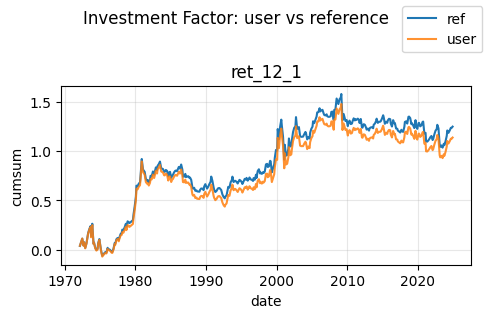

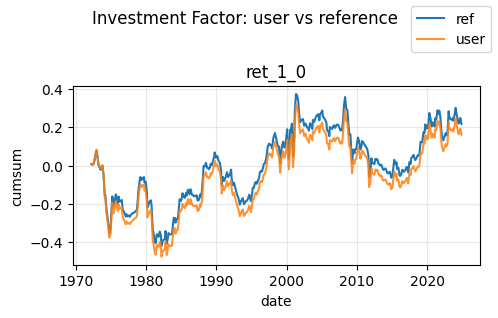

In [607]:
report_data = []
for name in final_results['name'].unique():
    test = final_results[final_results['name'] == name].loc[:, ['ret_vw']].rename(columns= {'ret_vw' : name})
    report = validator.validate_factor(
        user=test,
        reference=investment_factor_answer.loc[:, [name]],
        return_plot=True,
        plot_title="Investment Factor: user vs reference",
    )
    report_data.append({
        "Factor": name,
        "N": report.n_obs,
        "Start": report.date_start.date(),
        "End": report.date_end.date(),
        "MSE": report.mse,
        "RMSE": report.rmse,
        "MAE": report.mae,
        "Corr": report.corr,
    })

results_df = pd.DataFrame(report_data)
print(results_df.to_string(index=False))

### vw_cap

In [608]:
investment_factor_answer =q.load_factors(
    country="usa",
    dataset='factor',
    weighting='vw_cap',
    factors=['be_me', 'ope_be', 'at_gr1', 'ret_12_1', 'ret_1_0'],
)

  Factor   N      Start        End      MSE     RMSE      MAE     Corr
   be_me 370 1972-02-29 2024-11-30 0.000043 0.006544 0.004695 0.989128
  ope_be 370 1972-02-29 2024-11-30 0.000036 0.005994 0.004500 0.981963
  at_gr1 370 1972-02-29 2024-11-30 0.000023 0.004811 0.003560 0.988633
ret_12_1 370 1972-02-29 2024-11-30 0.000031 0.005562 0.004191 0.992974
 ret_1_0 370 1972-02-29 2024-11-30 0.000028 0.005281 0.003921 0.988580


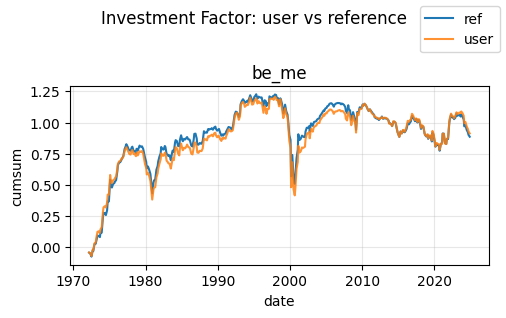

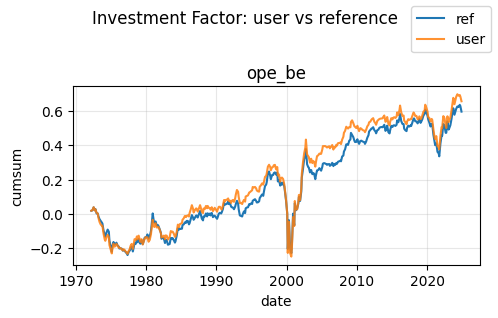

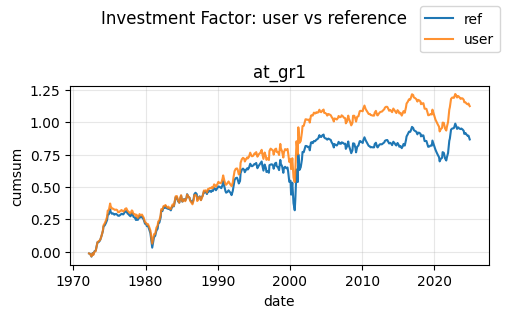

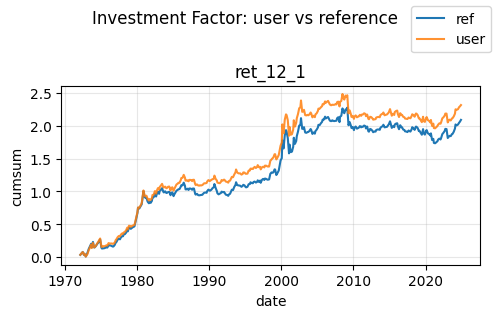

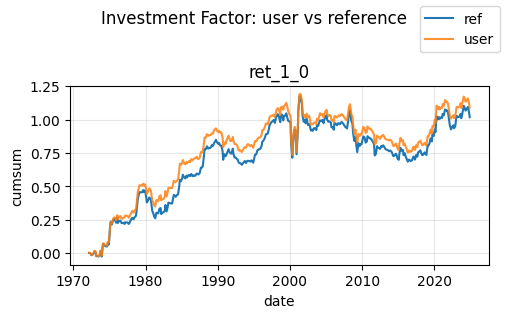

In [609]:
report_data = []
for name in final_results['name'].unique():
    test = final_results[final_results['name'] == name].loc[:, ['ret_capped_vw']].rename(columns= {'ret_capped_vw' : name})
    report = validator.validate_factor(
        user=test,
        reference=investment_factor_answer.loc[:, [name]],
        return_plot=True,
        plot_title="Investment Factor: user vs reference",
    )
    report_data.append({
        "Factor": name,
        "N": report.n_obs,
        "Start": report.date_start.date(),
        "End": report.date_end.date(),
        "MSE": report.mse,
        "RMSE": report.rmse,
        "MAE": report.mae,
        "Corr": report.corr,
    })

results_df = pd.DataFrame(report_data)
print(results_df.to_string(index=False))

### SMB 확인

In [610]:
mkt_ew_df =q.load_factors(
    country="usa",
    dataset='mkt',
    weighting='ew',
)

mkt_vw_df =q.load_factors(
    country="usa",
    dataset='mkt',
    weighting='vw',
)

mkt_cvw_df =q.load_factors(
    country="usa",
    dataset='mkt',
    weighting='vw_cap',
)

mkt_ew_df.head()
mkt_vw_df.head()
mkt_cvw_df.head()

,mkt
date,
1926-01-31,0.001037
1926-02-28,-0.046912
1926-03-31,-0.079126
1926-04-30,0.034092
1926-05-31,0.009215


In [611]:
mkt_df = mkt_ew_df.merge(mkt_vw_df , left_index= True , right_index=True , how='left')
mkt_df = mkt_df.merge(mkt_cvw_df , left_index= True , right_index=True , how='left')
mkt_df.columns = ['ret_ew', 'ret_vw', 'ret_capped_vw']

In [612]:
mkt_df.head()
mkt_df['name'] = 'mkt'

In [613]:
mkt_df.head()

,ret_ew,ret_vw,ret_capped_vw,name
date,,,,
1926-01-31,0.020608,-0.002409,0.001037,mkt
1926-02-28,-0.056506,-0.035821,-0.046912,mkt
1926-03-31,-0.099182,-0.066672,-0.079126,mkt
1926-04-30,0.029410,0.033847,0.034092,mkt
1926-05-31,0.000308,0.011772,0.009215,mkt


In [614]:
factors_df = factors_df.loc[: , ['ret_ew', 'ret_vw', 'ret_capped_vw', 'name']]
factors_df.head()

,ret_ew,ret_vw,ret_capped_vw,name
date,,,,
1972-02-29,-0.037187,-0.049118,-0.043874,be_me
1972-03-29,-0.018972,-0.025557,-0.014005,be_me
1972-04-30,-0.004905,-0.026692,-0.005942,be_me
1972-05-30,-0.050430,-0.013333,-0.049889,be_me
1972-06-30,-0.017247,-0.033412,-0.022476,be_me


In [615]:
factors_df = pd.concat([factors_df, mkt_df])

In [ ]:
factors_df.head() 

,ret_ew,ret_vw,ret_capped_vw,name
date,,,,
1972-02-29,-0.037187,-0.049118,-0.043874,be_me
1972-03-29,-0.018972,-0.025557,-0.014005,be_me
1972-04-30,-0.004905,-0.026692,-0.005942,be_me
1972-05-30,-0.050430,-0.013333,-0.049889,be_me
1972-06-30,-0.017247,-0.033412,-0.022476,be_me


In [617]:
factors_avg_df = factors_df.groupby([factors_df.index]).agg(
    avg_ret_ew = ('ret_ew', 'mean'),
    avg_ret_vw = ('ret_vw', 'mean'),
    avg_ret_cvw = ('ret_capped_vw', 'mean')
)

In [618]:
factors_avg_df['avg_ret_ew']

date
1926-01-31    0.020608
1926-02-28   -0.056506
1926-03-31   -0.099182
1926-04-30    0.029410
1926-05-31    0.000308
                ...   
2024-11-30   -0.009653
2024-12-30   -0.003966
2025-01-31         NaN
2025-02-28         NaN
2025-03-28         NaN
Name: avg_ret_ew, Length: 1451, dtype: float64

In [620]:
factors_df.head()

,ret_ew,ret_vw,ret_capped_vw,name
date,,,,
1972-02-29,-0.037187,-0.049118,-0.043874,be_me
1972-03-29,-0.018972,-0.025557,-0.014005,be_me
1972-04-30,-0.004905,-0.026692,-0.005942,be_me
1972-05-30,-0.050430,-0.013333,-0.049889,be_me
1972-06-30,-0.017247,-0.033412,-0.022476,be_me


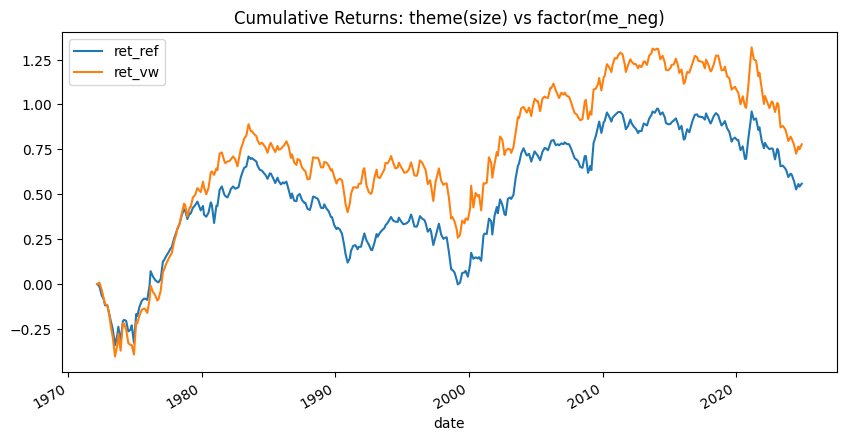

In [645]:
themes_df =q.load_factors(
    country="usa",
    dataset='theme',
    weighting='vw',
)
fig, ax = plt.subplots(figsize=(10,5))

merged = pd.concat([
	themes_df[themes_df.index >= '1972-02-29']['size'].cumsum().reset_index().set_index('date').rename(columns={'size':'ret_ref'}),
    factors_df[factors_df['name'] == 'me_neg']['ret_vw'].cumsum().reset_index().set_index('date').rename(columns={'ret_ew':'ret_user'})
], axis=1).dropna()

merged.plot(ax=ax)
plt.title("Cumulative Returns: theme(size) vs factor(me_neg)")
plt.show()


검증 리포트:
관측치수: 370 시작일: 1972-02-29 00:00:00 종료일: 2024-11-30 00:00:00
mse: 0.000 rmse: 0.015 mae: 0.010 corr: 0.908


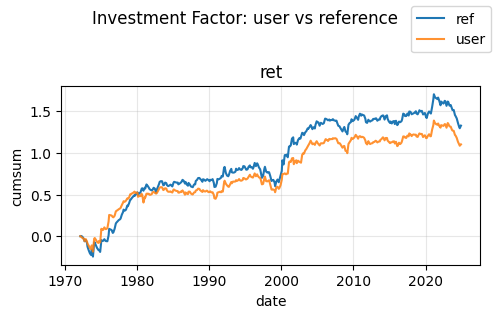

In [647]:
df1 = themes_df[themes_df.index >= '1972-02-29'][['size']].rename(columns={'size':'ret_ref'})
df2 = factors_df[factors_df['name'] == 'me_neg'][['ret_vw']].reset_index().set_index('date').rename(columns={'ret_vw':'ret_user'})

report = validator.validate_factor(
        user=df1.rename(columns={'ret_ref': 'ret'}),
        reference=df2.rename(columns={'ret_user': 'ret'}),
        return_plot=True,
        plot_title="Investment Factor: user vs reference",
    )

print("\n검증 리포트:")
print("관측치수:", report.n_obs, "시작일:", report.date_start, "종료일:", report.date_end)

def _fmt(x):
    return f"{x:.3f}" if x is not None else "nan"

print(
    "mse:", _fmt(report.mse),
    "rmse:", _fmt(report.rmse),
    "mae:", _fmt(report.mae),
    "corr:", _fmt(report.corr),
)

In [ ]:
# 전체 팩터 합친 수익률 계산 필요